#Functions and imports

**Installing dependencies**

*Run these cells if this is the first time that this notebook is being executed.*

In [ ]:
#pip install pykan
#pip install torch

'''
PyKAN requirements:
  #python==3.9.7
  matplotlib==3.6.2
  numpy==1.26.4
  scikit_learn==1.1.3
  setuptools==65.5.0
  sympy==1.11.1
  torch==2.2.2
  tqdm==4.66.2
  pandas==2.0.1
  seaborn
  pyyaml
'''

'\nPyKAN requirements:\n  #python==3.9.7\n  matplotlib==3.6.2\n  numpy==1.26.4\n  scikit_learn==1.1.3\n  setuptools==65.5.0\n  sympy==1.11.1\n  torch==2.2.2\n  tqdm==4.66.2\n  pandas==2.0.1\n  seaborn\n  pyyaml\n'

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp, odeint
import pandas as pd
import itertools
import matplotlib.pyplot as plt

#--- Reproductibility ---
%env PYTHONHASHSEED=0
from numpy.random import seed
seed(100)
import torch
torch.manual_seed(100)
torch.cuda.manual_seed(100)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms(True)

#Torch configs
torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from kan import KAN
from kan.utils import add_symbolic, ex_round
from kan.compiler import kanpiler
from sklearn.model_selection import train_test_split
from sympy import *

#Error eval
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy import stats

#Extra optimizer
from sklearn.linear_model import OrthogonalMatchingPursuit

#Danger zone:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
np.seterr(divide='ignore', invalid='ignore')   #the Wilcoxon test throws an error when there's a perfect fit

env: PYTHONHASHSEED=0


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

##Definitions

In [ ]:
def get_dataset(d_in,d_out, size=0.2, random_state=42):
  x_train, x_test, y_train, y_test = train_test_split(d_in, d_out,
                                                      test_size=0.2,
                                                      random_state=42,
                                                      shuffle=False)    #it's a time series, it should not be shuffled

  x_train_tensor = torch.tensor(x_train, dtype=torch.float64)
  x_test_tensor = torch.tensor(x_test, dtype=torch.float64)
  y_train_tensor = torch.tensor(y_train, dtype=torch.float64)
  y_test_tensor = torch.tensor(y_test, dtype=torch.float64)

  dataset = {'train_input': x_train_tensor, 'train_label': y_train_tensor,
             'test_input': x_test_tensor, 'test_label': y_test_tensor}

  return dataset

All structures below are quite similar, but we need to have a cell for each dynamics to take the equations into consideration correctly.

In [ ]:
def volterra(t, y, a=2, b=0.5, c=1, d=0.375):
  u,v = y
  dudt = a*u - b*u*v
  dvdt = -c*v + d*b*u*v

  return [dudt, dvdt]

In [ ]:
def pendulum(t, y):
    theta, omega = y
    g = 9.8
    L = 1.0

    d_theta = omega
    d_omega = - (g / L) * np.sin(theta)

    return [d_theta, d_omega]

In [ ]:
def lorenz(t, ivp_sol, sigma=2.0, rho=1.0, beta=2.6):
  x, y, z = ivp_sol
  dx_dt = sigma * (y - x)
  dy_dt = x * (rho - z) - y
  dz_dt = x * y - beta * z

  return [dx_dt, dy_dt, dz_dt]

In [ ]:
#=== SIS ===
def sis(t, y, beta = 0.3, gamma = 0.1):
  S, I = y
  dSdt = -beta * S * I + gamma * I
  dIdt = beta * S * I - gamma * I
  return [dSdt, dIdt]

In [ ]:
#=== SIR ===
def sir(t, y, beta=0.3, gamma=0.1):
  S, I, R = y
  dSdt = -beta * S * I
  dIdt = beta * S * I - gamma * I
  dRdt = gamma*I
  return [dSdt, dIdt, dRdt]

In [ ]:
#=== SEIR ===
def seir(t, y, beta=0.3, alpha=0.2, gamma=1.0):
    S, E, I, R = y
    dSdt = -beta * S * I
    dEdt = beta * S * I - alpha * E
    dIdt = alpha * E - gamma * I
    dRdt = gamma * I
    return [dSdt, dEdt, dIdt, dRdt]

In [ ]:
 #=== SEIRD ===
def seird(t, y, beta=0.3, alpha=0.2, gamma=1.0, mu=0.1):
    S, E, I, R, D = y
    dSdt = -beta * S * I
    dEdt = beta * S * I - alpha * E
    dIdt = alpha * E - (gamma + mu) * I
    dRdt = gamma * I
    dDdt = mu * I
    return [dSdt, dEdt, dIdt, dRdt, dDdt]

In [ ]:
 #=== SIRV ===
def sirv(t, y, beta=0.5, gamma=1.0, nu=0.5):
    S, I, R, V = y
    dSdt = -beta * S * I - nu * S
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    dVdt = nu * S
    return [dSdt, dIdt, dRdt, dVdt]

In [ ]:
 #=== SIRS ===
def sirs(t, y, beta=0.3, gamma=1.0, nu=0.2):
    S, I, R = y
    dSdt = -beta * S * I + nu * R
    dIdt =  beta * S * I - gamma * I
    dRdt = gamma * I- nu * R
    return [dSdt, dIdt, dRdt]

##Error evaluation

In [ ]:
def error_eval(dyn_name, curves_names, y_preds, targets):
  '''
  This function assumes you've run one of the eval_models() functions previously
  to estimate y_true and y_pred to keep it compatible with all dynamics.
  '''

  #Metrics
  mse = []
  mae = []
  r2 = []
  rmse = []
  statistics = []
  p_values = []
  wilcoxon_sol = []

  #y_int = model.predict(init_params)
  len_sol = len(y_preds)

  for i in range(len_sol):
    mse.append(mean_squared_error(y_preds[i], targets[i]))
    mae.append(mean_absolute_error(y_preds[i], targets[i]))
    if (r2_score(y_preds[i], targets[i]) < 0):
      r2.append(0)
    else:
      r2.append(r2_score(y_preds[i], targets[i]))
    rmse.append(np.sqrt(mean_squared_error(y_preds[i], targets[i])))

    #Wilcoxon test
    if np.allclose(targets[i], y_preds[i], rtol=1e-5, atol=1e-8):
      stat, p_value = 0.0, 1.0
    else:
      try:
        stat, p_value = stats.wilcoxon(targets[i], y_preds[i], zero_method="pratt")# stats.wilcoxon(y_true, y_pred)
      except ValueError:
        stat, p_value = np.nan, 1.0

    statistics.append(stat)
    p_values.append(p_value)
    wilcoxon_sol.append(1 if p_value < 0.05 else 0)


  res = pd.DataFrame(data={'dynamics': np.repeat(dyn_name,len_sol), 'axis': curves_names,
                           'mae': mae, 'mse': mse, 'r2': r2, 'rmse':rmse,
                           'wilcoxon_raw_value': statistics,
                           'p-value': p_values,
                           'is_difference': wilcoxon_sol})

  return res

#Dynamics to investigate

##Lorenz

In [ ]:
#Parameters
feature_names = ['X', 'Y', 'Z']
t_start = 0.0
t_end = 5.0
t_step = 0.02
t_eval = np.arange(t_start, t_end, t_step)
t_span = (t_start, t_end)

x0, y0, z0 = 0.6, 2.0, 1.0  #Initial conditions
state0 = [x0, y0, z0]

In [ ]:
#Solve the system
solution = solve_ivp(lorenz, t_span, state0, method='RK45', t_eval=t_eval)

#Target variables
dxdt = lorenz([0], solution.y)[0]
dydt = lorenz([0], solution.y)[1]
dzdt = lorenz([0], solution.y)[2]
targets = [dxdt,dydt,dzdt]

#->Split the data into training and test sets. The structure is get_dataset(X,y)
dataset_dxdt = get_dataset(solution.y.T[:, [0, 1]], [[item] for item in dxdt])
dataset_dydt = get_dataset(solution.y.T[:, [0, 1, 2]], [[item] for item in dydt])
dataset_dzdt = get_dataset(solution.y.T[:, [0,1,2]], [[item] for item in dzdt])

In [ ]:
#Applies PyKAN to the dynamics

#=== dxdt
x, y = symbols('x y')
expr = y - x
model_dx = kanpiler([x, y], expr)
model_dx.get_act(dataset_dxdt)
model_dx.fit(dataset_dxdt, steps=60, lamb=1e-35, lamb_coef=1e-2);

formula_dx, variables_dx = model_dx.symbolic_formula(var=['x', 'y'])

#=== dydt
x, y, z= symbols('x y z')
expr = x - x * z - y
model_dy = kanpiler([x,y,z], expr)
model_dy.get_act(dataset_dydt)
model_dy.fit(dataset_dydt, steps=60, lamb=1e-35, lamb_coef=1e-2);

formula_dy, variables_dy = model_dy.symbolic_formula(var=['x', 'y', 'z'])

#=== dzdt
x, y, z= symbols('x y z')
expr = x * y -  z
model_dz = kanpiler([x, y, z], expr)
model_dz.get_act(dataset_dzdt)
model_dz.fit(dataset_dzdt, steps=60, lamb=1e-35, lamb_coef=1e-2);

formula_dz, variables_dz = model_dz.symbolic_formula(var=['x', 'y', 'z'])

| train_loss: 3.02e-16 | test_loss: 2.20e-16 | reg: 6.91e-04 | : 100%|█| 60/60 [00:00<00:00, 77.58it
| train_loss: 4.50e-17 | test_loss: 2.45e-17 | reg: 8.63e-03 | : 100%|█| 60/60 [00:00<00:00, 179.38i
| train_loss: 1.08e-10 | test_loss: 8.69e-11 | reg: 5.30e-03 | : 100%|█| 60/60 [00:00<00:00, 94.13it


In [ ]:
#Best equations:
print('dxdt =', ex_round(expand(ex_round(model_dx.symbolic_formula(var=['x', 'y'])[0][0],5)),3))
print('dydt =', ex_round(expand(ex_round(model_dy.symbolic_formula(var=['x', 'y', 'z'])[0][0],5)),3))
print('dzdt =', ex_round(expand(ex_round(model_dz.symbolic_formula(var=['x', 'y', 'z'])[0][0],5)),3))

dxdt = -2.0*x + 2.0*y
dydt = -1.0*x*z + 1.0*x - 1.0*y
dzdt = 1.0*x*y - 2.6*z


In [ ]:
#Needs to be done by hand for now. Is there a better way to get the results?
#What I did: look up on the formulas and try to redo them.

#x: solution.y[0]
#y: solution.y[1]
#z: solution.y[2]

dxdt_pred = -2.0 * solution.y[0]  + 2.0*solution.y[1]
dydt_pred = -1.0 * solution.y[0]*solution.y[2] + 1.0*solution.y[0] - 0.1*solution.y[1]
dzdt_pred = 1.0*solution.y[0]*solution.y[1] - 2.6*solution.y[2]

y_preds = [dxdt_pred,dydt_pred,dzdt_pred]

In [ ]:
res = error_eval('Lorenz', feature_names, y_preds=y_preds, targets=targets)
res

,dynamics,axis,mae,mse,r2,rmse,wilcoxon_raw_value,p-value,is_difference
0,Lorenz,X,0.000000,0.000000,1.0,0.000000,0.0,1.000000e+00,0
1,Lorenz,Y,0.713699,0.597932,0.0,0.773261,0.0,9.254425e-43,1
2,Lorenz,Z,0.000000,0.000000,1.0,0.000000,0.0,1.000000e+00,0


##Lotka-Volterra

In [ ]:
#Parameters
feature_names = ['u', 'v']

t_start = 0.0
t_end = 7.5
t_step = 0.1
t_eval = np.arange(t_start, t_end, t_step)
t_span = (t_start, t_end)

state0 = np.array([20, 5])

In [ ]:
#Solve the system
solution = solve_ivp(volterra, t_span, state0, t_eval=t_eval)

#Target variables
dudt = volterra([0], solution.y)[0]
dvdt = volterra([0], solution.y)[1]
targets = [dudt,dvdt]

#->Split the data into training and test sets. The structure is get_dataset(X,y)
dataset_dudt = get_dataset(solution.y.T, [[item] for item in dudt])
dataset_dvdt = get_dataset(solution.y.T, [[item] for item in dvdt])

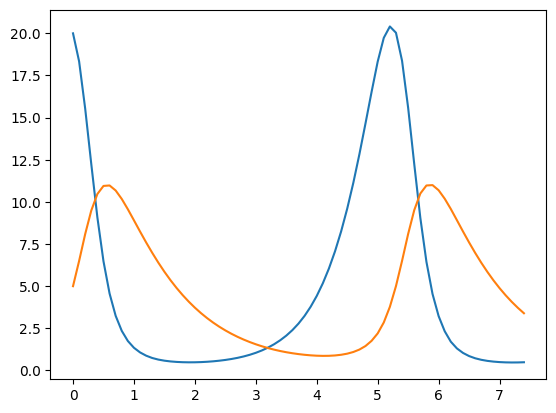

In [ ]:
plt.plot(t_eval,solution.y[0])
plt.plot(t_eval,solution.y[1])

In [ ]:
#Applies PyKAN to the dynamics
#Note: given that the model uses N features to find a single target, we need to
#do one model for each target variable. That does let all models see the full data.

#=== dudt
u, v = symbols('u v')
expr = u- u*v
model_du = kanpiler([u,v], expr)
model_du.get_act(dataset_dudt)
model_du.fit(dataset_dudt, steps=60, lamb=1e-35, lamb_coef=1e-2);

formula_du, variables_du = model_du.symbolic_formula(var=['u', 'v'])

#=== dvdt
u, v = symbols('u v')
expr = -v + u*v
model_dv = kanpiler([u, v], expr)
model_dv.get_act(dataset_dvdt)
model_dv.fit(dataset_dvdt, steps=200, lamb=1e-35, lamb_coef=1e-2);

formula_dv, variables_dv = model_dv.symbolic_formula(var=['u', 'v'])

| train_loss: 4.91e-15 | test_loss: 1.08e-15 | reg: 2.00e-01 | : 100%|█| 60/60 [00:01<00:00, 35.18it
| train_loss: 3.47e-13 | test_loss: 7.22e-14 | reg: 3.25e-01 | : 100%|█| 200/200 [00:03<00:00, 53.60


In [ ]:
#Best equations:
print('dudt =', ex_round(expand(ex_round(model_du.symbolic_formula(var=['u', 'v'])[0][0],5)),3))
print('dvdt =', ex_round(expand(ex_round(model_dv.symbolic_formula(var=['u', 'v'])[0][0],5)),3))

dudt = -0.5*u*v + 2.0*u
dvdt = 0.188*u*v - 1.0*v


In [ ]:
#Needs to be done by hand for now. Is there a better way to get the results?
#What I did: look up on the formulas and try to redo them.

#u: solution.y[0]
#v: solution.y[1]

dudt_pred = -0.5*solution.y[0]*solution.y[1] + 2.0*solution.y[0]
dvdt_pred = 0.187*solution.y[0]*solution.y[1] - 1.0*solution.y[1]

y_preds = [dudt_pred,dvdt_pred]

In [ ]:
res = error_eval('Lotka-Volterra', feature_names, y_preds=y_preds, targets=targets)
res

,dynamics,axis,mae,mse,r2,rmse,wilcoxon_raw_value,p-value,is_difference
0,Lotka-Volterra,u,0.000000,0.000000,1.000000,0.000000,0.0,1.000000e+00,0
1,Lotka-Volterra,v,0.012893,0.000526,0.999986,0.022939,0.0,5.280373e-14,1


##Simple pendulum

In [ ]:
#Parameters
feature_names = ['theta', 'omega']

t_start = 0.0
t_end = 10
t_step = 0.01
t_eval = np.arange(t_start, t_end, t_step)
t_span = (t_start, t_end)

state0 = np.array([0,np.radians(45)])

In [ ]:
#Solve the system
solution = solve_ivp(pendulum, t_span, state0, t_eval=t_eval)

#Target variables
dthetadt = pendulum([0], solution.y)[0]
domegadt = pendulum([0], solution.y)[1]
targets = [dthetadt,domegadt]

#->Split the data into training and test sets. The structure is get_dataset(X,y)
dataset_dthetadt = get_dataset(solution.y.T[:, [1]], [[item] for item in dthetadt])
dataset_domegadt = get_dataset(solution.y.T[:, [0]], [[item] for item in domegadt])

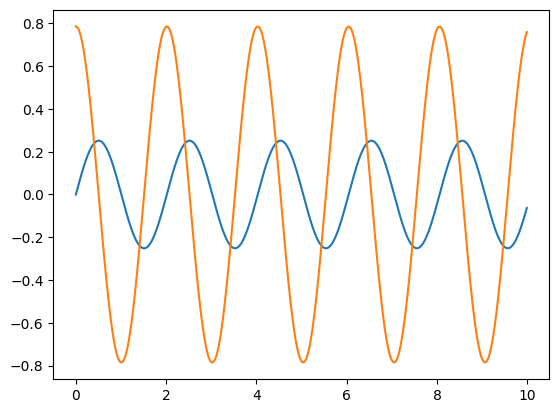

In [ ]:
plt.plot(t_eval,solution.y[0])
plt.plot(t_eval,solution.y[1])

In [ ]:
#Applies PyKAN to the dynamics

#=== dthetadt
model_dthetadt = KAN(width=[1,1], grid=3, base_fun='identity',seed=12)
model_dthetadt.get_act(dataset_dthetadt)
model_dthetadt.fit(dataset_dthetadt, steps=100, lamb=1e-15, lamb_coef=1.0)

#=== domegadt
model_domegadt = KAN(width=[1,1], grid=3, base_fun='identity',seed=12)
model_domegadt.get_act(dataset_domegadt)
model_domegadt.fit(dataset_domegadt, steps=100, lamb=1e-15, lamb_coef=1.0)

In [ ]:
#dthetadt is zero here. We need to refine the results.
model_dthetadt.suggest_symbolic(0,0,0)

  function  fitting r2    r2 loss  complexity  complexity loss  total loss
0        x    1.000000 -16.609602           1                1   -2.521920
1      exp    0.999999 -16.523077           2                2   -1.704615
2      sin    0.999999 -16.410345           2                2   -1.682069
3      cos    0.999999 -16.410345           2                2   -1.682069
4      x^2    0.999985 -15.261438           2                2   -1.452288


('x',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  1,
  <function kan.utils.<lambda>(x, y_th)>),
 np.float64(0.9999999997319081),
 np.int64(1))

In [ ]:
#Same thing for domegadt
model_domegadt.suggest_symbolic(0,0,0)

  function  fitting r2    r2 loss  complexity  complexity loss  total loss
0        x    0.999993 -15.848057           1                1   -2.369611
1      sin    1.000000 -16.605820           2                2   -1.721164
2      cos    1.000000 -16.604999           2                2   -1.721000
3      exp    0.999993 -15.843667           2                2   -1.568733
4      x^2    0.999992 -15.725056           2                2   -1.545011


('x',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  1,
  <function kan.utils.<lambda>(x, y_th)>),
 np.float64(0.9999930464903092),
 np.int64(1))

In [ ]:
#And here we are choosing 'x' and 'sin' as that's the closest to the real functions.
#-> Notice that, if unknown, the choice with the best r² should be the one picked.
model_dthetadt.fix_symbolic(0,0,0,'x')
model_domegadt.fix_symbolic(0,0,0,'sin')

Best value at boundary.
r2 is 0.9999999997319081
saving model version 0.2
r2 is 0.9999999734865148
saving model version 0.2


tensor(1.0000)

In [ ]:
#Best equations:
print('dthetadt =', ex_round(expand(ex_round(model_dthetadt.symbolic_formula(var=['omega'])[0][0],5)),3))
print('domegadt =', ex_round(expand(ex_round(model_domegadt.symbolic_formula(var=['theta'])[0][0],5)),3))

dthetadt = 1.0*omega
domegadt = -9.791*sin(1.001*theta)


In [ ]:
#Needs to be done by hand for now. Is there a better way to get the results?
#What I did: look up on the formulas and try to redo them.

#theta: solution.y[0]
#omega: solution.y[1]

dthetadt_pred = 1 * solution.y[1]
domegadt_pred = -9.791 * np.sin(1.001*solution.y[0])

y_preds = [dthetadt_pred,domegadt_pred]

In [ ]:
res = error_eval('Pendulum', feature_names, y_preds=y_preds, targets=targets)
res

,dynamics,axis,mae,mse,r2,rmse,wilcoxon_raw_value,p-value,is_difference
0,Pendulum,theta,0.000000,0.000000e+00,1.0,0.000000,0.0,1.00000,0
1,Pendulum,omega,0.000104,1.275351e-08,1.0,0.000113,249901.0,0.96957,0


##SIR

In [ ]:
#Parameters
feature_names = ['S', 'I', 'R']
#Time
t_start = 0.0
t_end = 100.0
t_step =  0.1
t_span = (t_start, t_end)
t_eval = np.arange(t_start, t_end, t_step)

N = 1
I0, R0 = 0.001, 0.0
S0 = N - I0 - R0
x0 = np.array([S0, I0, R0])

#They're hardcoded in the SIR function definition. Just stating them here for reference
beta=0.3
gamma=0.1

In [ ]:
#Solve the SIR system
solution = solve_ivp(sir, t_span, x0, t_eval=t_eval)

dSdt = sir([0], solution.y)[0]
dIdt = sir([0], solution.y)[1]
dRdt = sir([0], solution.y)[2]
targets = [dSdt,dIdt,dRdt]

#->Split the data into training and test sets. The structure is get_dataset(X,y)
dataset_dSdt = get_dataset(solution.y.T[:, [0, 1]], [[item] for item in dSdt])
dataset_dIdt = get_dataset(solution.y.T[:, [0, 1]], [[item] for item in dIdt])
dataset_dRdt = get_dataset(solution.y.T[:, [1]], [[item] for item in dRdt])

In [ ]:
#Applies PyKAN to the dynamics

#=== dSdt
S, I = symbols('S I')
expr = - S * I
model_dS = kanpiler([S, I], expr)
model_dS.get_act(dataset_dSdt)
model_dS.fit(dataset_dSdt, steps=50, lamb=1e-15, lamb_coef=1e-5)

#=== dIdt
S, I = symbols('S I')
expr = S * I-I
model_dI = kanpiler([S, I], expr)
model_dI.get_act(dataset_dIdt)
model_dI.fit(dataset_dIdt, steps=30, lamb=1e-15, lamb_coef=1e-5)

#=== dRdt
model_dR = KAN(width=[1,1], grid=3, base_fun='identity',seed=12)
model_dR.get_act(dataset_dRdt)
model_dR.fit(dataset_dRdt, steps=50, lamb=1e-15, lamb_coef=1.0)

In [ ]:
#dRdt is zero here. We need to refine the results.
model_dR.suggest_symbolic(0,0,0)

  function  fitting r2    r2 loss  complexity  complexity loss  total loss
0    1/x^2    0.999998 -16.306899           2                2   -1.661380
1      exp    0.999995 -16.071917           2                2   -1.614383
2      1/x    0.999982 -15.129807           2                2   -1.425961
3      x^5    0.999999 -16.500809           3                3   -0.900162
4    1/x^3    0.999999 -16.467959           3                3   -0.893592


('1/x^2',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  2,
  <function kan.utils.<lambda>(x, y_th)>),
 np.float64(0.9999976651373044),
 np.int64(2))

In [ ]:
#We're accepting the best fit result, not what's actually given by the SIRS model.
model_dR.fix_symbolic(0,0,0,'1/x^2')

r2 is 0.9999976651373044
saving model version 0.2


tensor(1.0000)

In [ ]:
print('dRdt =', ex_round(expand(ex_round(model_dR.symbolic_formula(var=['I'])[0][0],5)),3))

dRdt = 0.314


In [ ]:
#If we go by SIRS model, PyKAN finds the right equation.
model_dR.fix_symbolic(0,0,0,'x')

Best value at boundary.
r2 is 0.16461357133683022
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.3


-100000000.0

In [ ]:
#Best equations:
print('dSdt =', ex_round(expand(ex_round(model_dS.symbolic_formula(var=['S', 'I'])[0][0],5)),3))
print('dIdt =', ex_round(expand(ex_round(model_dI.symbolic_formula(var=['S', 'I'])[0][0],5)),3))
print('dRdt =', ex_round(expand(ex_round(model_dR.symbolic_formula(var=['I'])[0][0],5)),3))

dSdt = -0.3*I*S
dIdt = 0.3*I*S - 0.1*I
dRdt = 0.1*I


In [ ]:
#Needs to be done by hand for now. Is there a better way to get the results?
#What I did: look up on the formulas and try to redo them.

#S: solution.y[0]
#I: solution.y[1]
#R: solution.y[2]

dSdt_pred = -0.3 * solution.y[0]*solution.y[1]
dIdt_pred = 0.3 * solution.y[0]*solution.y[1] - 0.1*solution.y[1]
dRdt_pred = 0.1*solution.y[1]

y_preds = [dSdt_pred,dIdt_pred,dRdt_pred]

In [ ]:
res = error_eval('SIR', feature_names, y_preds=y_preds, targets=targets)
res

,dynamics,axis,mae,mse,r2,rmse,wilcoxon_raw_value,p-value,is_difference
0,SIR,S,0.0,0.0,1.0,0.0,0.0,1.0,0
1,SIR,I,0.0,0.0,1.0,0.0,0.0,1.0,0
2,SIR,R,0.0,0.0,1.0,0.0,0.0,1.0,0


##SIS

In [ ]:
#Parameters
feature_names = ['S', 'I']
#Time
t = np.linspace(0, 10, 100)
t_start = 0.0
t_end = 100.0
t_step =  0.1
t_span = (t_start, t_end)
t_eval = np.arange(t_start, t_end, t_step)

#SIS
N = 1
I0 = 0.001
S0 = N - I0
x0 = np.array([S0, I0])

In [ ]:
#Solve the SIS system
solution = solve_ivp(sis, t_span, x0, t_eval=t_eval)

#Target variables
dSdt = sis([0], solution.y)[0]
dIdt = sis([0], solution.y)[1]
targets = [dSdt,dIdt]

#->Split the data into training and test sets. The structure is get_dataset(X,y)
dataset_dSdt = get_dataset(solution.y.T, [[item] for item in dSdt])
dataset_dIdt = get_dataset(solution.y.T, [[item] for item in dIdt])

In [ ]:
#Applies PyKAN to the dynamics

#=== dSdt
S, I = symbols('S I')
expr = - S * I
model_dS = kanpiler([S, I], expr)
model_dS.get_act(dataset_dSdt)
model_dS.fit(dataset_dSdt, steps=60, lamb=1e-45, lamb_coef=1e-2)

#=== dIdt
S, I = symbols('S I')
expr = S * I
model_dI = kanpiler([S, I], expr)
model_dI.get_act(dataset_dIdt)
model_dI.fit(dataset_dIdt, steps=60, lamb=1e-25, lamb_coef=1e-12)

In [ ]:
#Best equations:
print('dSdt =', ex_round(expand(ex_round(model_dS.symbolic_formula(var=['S', 'I'])[0][0],5)),3))
print('dIdt =', ex_round(expand(ex_round(model_dI.symbolic_formula(var=['S', 'I'])[0][0],5)),3))

dSdt = -0.3*I*S + 0.1*I
dIdt = 0.3*I*S - 0.1*I


In [ ]:
#Needs to be done by hand for now. Is there a better way to get the results?
#What I did: look up on the formulas and try to redo them.

#S: solution.y[0]
#I: solution.y[1]

dSdt_pred = -0.3 * solution.y[0]*solution.y[1] + 0.1*solution.y[1]
dIdt_pred = 0.3 * solution.y[0]*solution.y[1] - 0.1*solution.y[1]

y_preds = [dSdt_pred,dIdt_pred]

In [ ]:
res = error_eval('SIS', feature_names, y_preds=y_preds, targets=targets)
res

,dynamics,axis,mae,mse,r2,rmse,wilcoxon_raw_value,p-value,is_difference
0,SIS,S,0.0,0.0,1.0,0.0,0.0,1.0,0
1,SIS,I,0.0,0.0,1.0,0.0,0.0,1.0,0


##SEIR

In [ ]:
#Parameters
feature_names = ['S', 'E', 'I', 'R']
#Time
t_start = 0.0
t_end = 100.0
t_step =  0.1   #why does it changes here?
t_span = (t_start, t_end)
t_eval = np.arange(t_start, t_end, t_step)

N = 1
I0, R0, E0 = 0.001, 0.0, 0.0
S0 = N - I0 - R0 - E0
x0 = np.array([S0, E0, I0, R0])

#They're hardcoded in the SIR function definition. Just stating them here for reference
beta = 0.3
gamma = 1.0
alpha = 0.2

In [ ]:
#Solve the SEIR system
solution = solve_ivp(seir, t_span, x0, t_eval=t_eval, args=(0.3, 0.2, 1.0))

#Target variables
dSdt = seir([0], solution.y)[0]
dEdt = seir([0], solution.y)[1]
dIdt = seir([0], solution.y)[2]
dRdt = seir([0], solution.y)[3]
targets = [dSdt,dEdt,dIdt,dRdt]

#->Split the data into training and test sets. The structure is get_dataset(X,y)
dataset_dSdt = get_dataset(solution.y.T[:, [0, 2]], [[item] for item in dSdt])
dataset_dEdt = get_dataset(solution.y.T[:, [0, 1, 2]], [[item] for item in dEdt])
dataset_dIdt = get_dataset(solution.y.T[:, [1, 2]], [[item] for item in dIdt])
dataset_dRdt = get_dataset(solution.y.T[:, [2]], [[item] for item in dRdt])

In [ ]:
#Applies PyKAN to the dynamics

#=== dSdt
S, I = symbols('S I')
expr = - S*I
model_dS = kanpiler([S, I], expr)
model_dS.get_act(dataset_dSdt)
model_dS.fit(dataset_dSdt, steps=50, lamb=1.5e-5, lamb_coef=150)

#=== dEdt
S, E, I = symbols('S E I')
expr =  S * I - E
model_dE = kanpiler([S,E, I], expr)
model_dE.get_act(dataset_dEdt)
model_dE.fit(dataset_dEdt, steps=50, lamb=1.0, lamb_coef=80)

#=== dIdt
E, I = symbols('E I')
expr = E - I
model_dI = kanpiler([E, I], expr)
model_dI.get_act(dataset_dIdt)
model_dI.fit(dataset_dIdt, steps=50, lamb=1e-15, lamb_coef=1.0)

#=== dRdt
model_dR = KAN(width=[1,1], grid=3,base_fun='identity',seed=12)
model_dR.get_act(dataset_dRdt)
model_dR.fit(dataset_dRdt, steps=50, lamb=1e-15, lamb_coef=1.0)

In [ ]:
#Best equations:
print('dSdt =', ex_round(expand(ex_round(model_dS.symbolic_formula(var=['S', 'I'])[0][0],5)),3))
print('dEdt =', ex_round(expand(ex_round(model_dE.symbolic_formula(var=['S', 'E', 'I'])[0][0],5)),3))
print('dIdt =', ex_round(expand(ex_round(model_dI.symbolic_formula(var=['E', 'I'])[0][0],5)),3))
print('dRdt =', ex_round(expand(ex_round(model_dR.symbolic_formula(var=['I'])[0][0],5)),3))

dSdt = -1.0*I*S
dEdt = -1.0*E + 1.0*I*S
dIdt = 0.2*E - 1.0*I
dRdt = 0


In [ ]:
model_dR.suggest_symbolic(0,0,0)

  function  fitting r2    r2 loss  complexity  complexity loss  total loss
0      1/x         1.0 -16.609638           2                2   -1.721928
1    1/x^2         1.0 -16.609638           2                2   -1.721928
2    1/x^3         1.0 -16.609638           3                3   -0.921928
3    1/x^4         1.0 -16.609640           4                4   -0.121928
4        0         0.0   0.000014           0                0    0.000003


('1/x',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  2,
  <function kan.utils.<lambda>(x, y_th)>),
 np.float64(0.9999999999835316),
 np.int64(2))

In [ ]:
model_dR.fix_symbolic(0,0,0,'1/x')

r2 is 0.9999999999835316
saving model version 0.2


tensor(1.0000)

In [ ]:
print('dRdt =', ex_round(expand(ex_round(model_dR.symbolic_formula(var=['I'])[0][0],5)),3))

dRdt = 1.0000


In [ ]:
model_dR.fix_symbolic(0,0,0,'x')

Best value at boundary.
r2 is 1.562963478040956e-14
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.3


-100000000.0

In [ ]:
print('dRdt =', ex_round(expand(ex_round(model_dR.symbolic_formula(var=['I'])[0][0],5)),3))

dRdt = 1.0*I


In [ ]:
#Needs to be done by hand for now. Is there a better way to get the results?
#What I did: look up on the formulas and try to redo them.

#S: solution.y[0]
#E: solution.y[1]
#I: solution.y[2]
#R: solution.y[3]

dSdt_pred = -1.0*solution.y[2]*solution.y[0]
dEdt_pred = -1.0*solution.y[1] + 1.0*solution.y[2]*solution.y[0]
dIdt_pred = 0.2*solution.y[1] - 1.0*solution.y[2]
dRdt_pred = 1*solution.y[2]

y_preds = [dSdt_pred,dEdt_pred,dIdt_pred,dRdt_pred]

In [ ]:
res = error_eval('SEIR', feature_names, y_preds=y_preds, targets=targets)
res

,dynamics,axis,mae,mse,r2,rmse,wilcoxon_raw_value,p-value,is_difference
0,SEIR,S,0.000011,2.870590e-09,0.490662,0.000054,72023.0,9.178067e-85,1
1,SEIR,E,0.000016,2.586269e-09,0.475180,0.000051,112091.0,1.138404e-51,1
2,SEIR,I,0.000000,0.000000e+00,1.000000,0.000000,0.0,1.000000e+00,0
3,SEIR,R,0.000000,0.000000e+00,1.000000,0.000000,0.0,1.000000e+00,0


Note: the curves seem to differ from the real solution by the extra coefficients added by PyKAN.

##SEIRD

In [ ]:
#Parameters
feature_names = ['S', 'E', 'I', 'R', 'D']
#Time
t_start = 0.0
t_end = 100.0
t_step =  0.1   #why does it changes here?
t_span = (t_start, t_end)
t_eval = np.arange(t_start, t_end, t_step)

N = 1
I0, R0, E0, D0 = 0.001, 0.0, 0.0, 0.0
S0 = N - I0 - R0 - E0 - D0
x0 = np.array([S0, E0, I0, R0, D0])

#They're hardcoded in the SIR function definition. Just stating them here for reference
beta = 0.3
gamma = 1.0
alpha = 0.2
mu = 0.1

In [ ]:
#Solve the SEIR system
solution = solve_ivp(seird, t_span, x0, t_eval=t_eval, args=(0.3, 0.2, 1.0, 0.1))

#Target variables
dSdt = seird([0], solution.y)[0]
dEdt = seird([0], solution.y)[1]
dIdt = seird([0], solution.y)[2]
dRdt = seird([0], solution.y)[3]
dDdt = seird([0], solution.y)[4]
targets = [dSdt,dEdt,dIdt,dRdt,dDdt]

#->Split the data into training and test sets. The structure is get_dataset(X,y)
dataset_dSdt = get_dataset(solution.y.T[:, [0, 2]], [[item] for item in dSdt])
dataset_dEdt = get_dataset(solution.y.T[:, [0, 1, 2]], [[item] for item in dEdt])
dataset_dIdt = get_dataset(solution.y.T[:, [1, 2]], [[item] for item in dIdt])
dataset_dRdt = get_dataset(solution.y.T[:, [2]], [[item] for item in dRdt])
dataset_dDdt = get_dataset(solution.y.T[:, [2]], [[item] for item in dDdt])

In [ ]:
#Applies PyKAN to the dynamics

#=== dSdt
S, I = symbols('S I')
expr = -I*S
model_dS = kanpiler([S, I], expr)
model_dS.get_act(dataset_dSdt)
model_dS.fit(dataset_dSdt, steps=70, lamb=1, lamb_coef=0.01)

#=== dEdt
S, E, I = symbols('S E I')
expr =  S*I - E
model_dE = kanpiler([S,E, I], expr)
model_dE.get_act(dataset_dEdt)
model_dE.fit(dataset_dEdt, steps=70, lamb=1, lamb_coef=0.01)

#=== dIdt
E, I = symbols('E I')
expr = E - I
model_dI = kanpiler([E, I], expr)
model_dI.get_act(dataset_dIdt)
model_dI.fit(dataset_dIdt, steps=50, lamb=1e-07, lamb_coef=1e-15)

#=== dRdt
model_dR = KAN(width=[1,1], grid=3, base_fun='identity',seed=12)
model_dR.get_act(dataset_dRdt)
model_dR.fit(dataset_dRdt, steps=50, lamb=1e-15, lamb_coef=1.0)

#=== dDdt
model_dD = KAN(width=[1,1], grid=3, base_fun='identity',seed=12)
model_dD.get_act(dataset_dDdt)
model_dD.fit(dataset_dDdt, steps=50, lamb=1e-15, lamb_coef=1.0)

In [ ]:
#Best equations:
print('dSdt =', ex_round(expand(ex_round(model_dS.symbolic_formula(var=['S', 'I'])[0][0],5)),3))
print('dEdt =', ex_round(expand(ex_round(model_dE.symbolic_formula(var=['S', 'E', 'I'])[0][0],5)),3))
print('dIdt =', ex_round(expand(ex_round(model_dI.symbolic_formula(var=['E', 'I'])[0][0],5)),3))
print('dRdt =', ex_round(expand(ex_round(model_dR.symbolic_formula(var=['I'])[0][0],5)),3))
print('dDdt =', ex_round(expand(ex_round(model_dD.symbolic_formula(var=['I'])[0][0],5)),3))

dSdt = -1.0*I*S
dEdt = -1.0*E + 1.0*I*S
dIdt = 0.2*E - 1.1*I
dRdt = 0
dDdt = 0


In [ ]:
#dRdt is zero here. We need to refine the results.
model_dR.suggest_symbolic(0,0,0)

  function  fitting r2    r2 loss  complexity  complexity loss  total loss
0      1/x         1.0 -16.609637           2                2   -1.721927
1    1/x^2         1.0 -16.609636           2                2   -1.721927
2    1/x^3         1.0 -16.609637           3                3   -0.921927
3    1/x^4         1.0 -16.609640           4                4   -0.121928
4        0         0.0   0.000014           0                0    0.000003


('1/x',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  2,
  <function kan.utils.<lambda>(x, y_th)>),
 np.float64(0.9999999999742101),
 np.int64(2))

In [ ]:
#Same thing goes for dDdt
model_dD.suggest_symbolic(0,0,0)

  function  fitting r2    r2 loss  complexity  complexity loss  total loss
0    1/x^2         1.0 -16.609407           2                2   -1.721881
1      1/x         1.0 -16.609402           2                2   -1.721880
2    1/x^3         1.0 -16.609634           3                3   -0.921927
3    1/x^4         1.0 -16.609640           4                4   -0.121928
4        0         0.0   0.000014           0                0    0.000003


('1/x^2',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  2,
  <function kan.utils.<lambda>(x, y_th)>),
 np.float64(0.9999999983811991),
 np.int64(2))

In [ ]:
model_dR.fix_symbolic(0,0,0,'1/x')
model_dD.fix_symbolic(0,0,0,'1/x^2')

r2 is 0.9999999999742101
saving model version 0.2
r2 is 0.9999999983811991
saving model version 0.2


tensor(1.0000)

In [ ]:
print('dRdt =', ex_round(expand(ex_round(model_dR.symbolic_formula(var=['I'])[0][0],5)),3))
print('dDdt =', ex_round(expand(ex_round(model_dD.symbolic_formula(var=['I'])[0][0],5)),3))

dRdt = 1.0000
dDdt = 0.050


In [ ]:
#We need to use previous knowledge on the equations once more
model_dR.fix_symbolic(0,0,0,'x')
model_dD.fix_symbolic(0,0,0,'x')

Best value at boundary.
r2 is 1.4429033884381846e-14
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.3
Best value at boundary.
r2 is 1.4435031384337942e-16
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.3


-100000000.0

In [ ]:
#Needs to be done by hand for now. Is there a better way to get the results?
#What I did: look up on the formulas and try to redo them.

#S: solution.y[0]
#E: solution.y[1]
#I: solution.y[2]
#R: solution.y[3]
#D: solution.y[4]

dSdt_pred = -1.0*solution.y[2]*solution.y[0]
dEdt_pred = -1.0*solution.y[1] + 1.0*solution.y[2]*solution.y[0]
dIdt_pred = 0.2*solution.y[1] - 1.1*solution.y[2]
dRdt_pred = 1.0*solution.y[2]
dDdt_pred = 0.1*solution.y[2]

y_preds = [dSdt_pred,dEdt_pred,dIdt_pred,dRdt_pred,dDdt_pred]

In [ ]:
res = error_eval('SEIRD', feature_names, y_preds=y_preds, targets=targets)
res

,dynamics,axis,mae,mse,r2,rmse,wilcoxon_raw_value,p-value,is_difference
0,SEIRD,S,0.000009,2.602785e-09,0.493536,0.000051,81173.0,1.793894e-76,1
1,SEIRD,E,0.000014,2.373228e-09,0.479921,0.000049,121043.0,2.053899e-45,1
2,SEIRD,I,0.000000,0.000000e+00,1.000000,0.000000,0.0,1.000000e+00,0
3,SEIRD,R,0.000000,0.000000e+00,1.000000,0.000000,0.0,1.000000e+00,0
4,SEIRD,D,0.000000,0.000000e+00,1.000000,0.000000,0.0,1.000000e+00,0


Note: the curves seem to differ from the real solution by the extra coefficients added by PyKAN.

Curves are a bit smoother here too.

##SIRV

In [ ]:
0#Parameters
feature_names = ['S', 'I', 'R', 'V']
#Time
t_start = 0.0
t_end = 100.0
t_step =  0.05
t_span = (t_start, t_end)
t_eval = np.arange(t_start, t_end, t_step)

N = 1
I0, R0, V0 = 0.001, 0.0, 0.0
S0 = N - I0 - R0 - V0
x0 = np.array([S0, I0, R0, V0])

#They're hardcoded in the SIR function definition. Just stating them here for reference
beta=0.3
gamma=0.1
nu=0.5

In [ ]:
#Solve the SIR system
solution = solve_ivp(sirv, t_span, x0, t_eval=t_eval)

dSdt = sirv([0], solution.y)[0]
dIdt = sirv([0], solution.y)[1]
dRdt = sirv([0], solution.y)[2]
dVdt = sirv([0], solution.y)[3]
targets = [dSdt,dIdt,dRdt,dVdt]

#->Split the data into training and test sets. The structure is get_dataset(X,y)
dataset_dSdt = get_dataset(solution.y.T[:, [0, 1]], [[item] for item in dSdt])
dataset_dIdt = get_dataset(solution.y.T[:, [0, 1]], [[item] for item in dIdt])
dataset_dRdt = get_dataset(solution.y.T[:, [1]], [[item] for item in dRdt])
dataset_dVdt = get_dataset(solution.y.T[:, [0]], [[item] for item in dVdt])

In [ ]:
#Applies PyKAN to the dynamics

#=== dSdt
S, I = symbols('S I')
expr = -S*I - S
model_dS = kanpiler([S, I], expr)
model_dS.get_act(dataset_dSdt)
model_dS.fit(dataset_dSdt, steps=500, lamb=1e-3, lamb_coef=1e-15)

#=== dIdt
S, I = symbols('S I')
expr = S * I-I
model_dI = kanpiler([S, I], expr)
model_dI.get_act(dataset_dIdt)
model_dI.fit(dataset_dIdt, steps=20, lamb=1e-3, lamb_coef=1e-15)

#=== dRdt
model_dR = KAN(width=[1,1], grid=2, base_fun='identity',seed=12)
model_dR.get_act(dataset_dRdt)
model_dR.fit(dataset_dRdt, steps=50, lamb=1e-15, lamb_coef=1.0)

#=== dVdt
model_dV = KAN(width=[1,1], grid=3, base_fun='identity',seed=12)
model_dV.get_act(dataset_dVdt)
model_dV.fit(dataset_dVdt, steps=50, lamb=1e-15, lamb_coef=1.0)

In [ ]:
#Best equations:
print('dSdt =', ex_round(expand(ex_round(model_dS.symbolic_formula(var=['S', 'I'])[0][0],5)),3))
print('dIdt =', ex_round(expand(ex_round(model_dI.symbolic_formula(var=['S', 'I'])[0][0],5)),3))
print('dRdt =', ex_round(expand(ex_round(model_dR.symbolic_formula(var=['I'])[0][0],5)),3))
print('dVdt =', ex_round(expand(ex_round(model_dV.symbolic_formula(var=['S'])[0][0],5)),3))

dSdt = -0.5*I*S - 0.5*S
dIdt = 0.5*I*S - 1.0*I
dRdt = 1.0*I
dVdt = 0


In [ ]:
#dRdt is zero here. We need to refine the results.
model_dR.suggest_symbolic(0,0,0)

  function  fitting r2    r2 loss  complexity  complexity loss  total loss
0      1/x         1.0 -16.609640           2                2   -1.721928
1    1/x^2         1.0 -16.609640           2                2   -1.721928
2    1/x^3         1.0 -16.609640           3                3   -0.921928
3    1/x^4         1.0 -16.609640           4                4   -0.121928
4        0         0.0   0.000014           0                0    0.000003


('1/x',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  2,
  <function kan.utils.<lambda>(x, y_th)>),
 np.float64(0.999999999999962),
 np.int64(2))

In [ ]:
#Same thing goes for dDdt
model_dV.suggest_symbolic(0,0,0)

  function    fitting r2    r2 loss  complexity  complexity loss  total loss
0    1/x^2  9.994024e-01 -10.684605           2                2   -0.536921
1        0  0.000000e+00   0.000014           0                0    0.000003
2    1/x^3  9.996372e-01 -11.389256           3                3    0.122149
3        x  4.260808e-48   0.000014           1                1    0.800003
4    1/x^4  9.996464e-01 -11.425547           4                4    0.914891


('1/x^2',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  2,
  <function kan.utils.<lambda>(x, y_th)>),
 np.float64(0.9994024059607396),
 np.int64(2))

In [ ]:
#We're accepting the best fit result, not what's actually given by the SIRS model.
model_dR.fix_symbolic(0,0,0,'1/x')
model_dV.fix_symbolic(0,0,0,'1/x^2')

r2 is 0.999999999999962
saving model version 0.4
r2 is 0.9994024059607396
saving model version 0.3


-100000000.0

In [ ]:
print('dRdt =', ex_round(expand(ex_round(model_dR.symbolic_formula(var=['I'])[0][0],5)),3))
print('dVdt =', ex_round(expand(ex_round(model_dV.symbolic_formula(var=['S'])[0][0],5)),3))

dRdt = 1.00000
dVdt = 0.249


In [ ]:
model_dR.fix_symbolic(0,0,0,'x')
model_dV.fix_symbolic(0,0,0,'x')

Best value at boundary.
r2 is 5.805407211488941e-14
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.5
Best value at boundary.
r2 is 4.2608078937149183e-48
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.4


-100000000.0

In [ ]:
print('dRdt =', ex_round(expand(ex_round(model_dR.symbolic_formula(var=['I'])[0][0],5)),3))
print('dVdt =', ex_round(expand(ex_round(model_dV.symbolic_formula(var=['S'])[0][0],5)),3))

dRdt = 1.0*I
dVdt = 0.499*S


In [ ]:
#Needs to be done by hand for now. Is there a better way to get the results?
#What I did: look up on the formulas and try to redo them.

#S: solution.y[0]
#I: solution.y[1]
#R: solution.y[2]
#V: solution.y[3]

dSdt_pred = -0.5*solution.y[1]*solution.y[0] - 0.5*solution.y[0]
dIdt_pred = 0.5*solution.y[1]*solution.y[0] - 1.0*solution.y[1]
dRdt_pred = 1.0*solution.y[1]
dVdt_pred = 0.5*solution.y[0]

y_preds = [dSdt_pred,dIdt_pred,dRdt_pred,dVdt_pred]

In [ ]:
res = error_eval('SIRV', feature_names, y_preds=y_preds, targets=targets)
res

,dynamics,axis,mae,mse,r2,rmse,wilcoxon_raw_value,p-value,is_difference
0,SIRV,S,0.0,0.0,1.0,0.0,0.0,1.0,0
1,SIRV,I,0.0,0.0,1.0,0.0,0.0,1.0,0
2,SIRV,R,0.0,0.0,1.0,0.0,0.0,1.0,0
3,SIRV,V,0.0,0.0,1.0,0.0,0.0,1.0,0


##SIRS

In [ ]:
#Parameters
feature_names = ['S', 'I', 'R']
#Time
t_start = 0.0
t_end = 100.0
t_step =  0.1
t_span = (t_start, t_end)
t_eval = np.arange(t_start, t_end, t_step)

N = 1
I0, R0 = 0.001, 0.0
S0 = N - I0 - R0
x0 = np.array([S0, I0, R0])

#They're hardcoded in the SIR function definition. Just stating them here for reference
beta=0.3
gamma=0.1

In [ ]:
#Solve the SIRS system
solution = solve_ivp(sirs, t_span, x0, t_eval=t_eval)

dSdt = sirs([0], solution.y)[0]
dIdt = sirs([0], solution.y)[1]
dRdt = sirs([0], solution.y)[2]
targets = [dSdt,dIdt,dRdt]

#->Split the data into training and test sets. The structure is get_dataset(X,y)
dataset_dSdt = get_dataset(solution.y.T[:, [0,1,2]], [[item] for item in dSdt])
dataset_dIdt = get_dataset(solution.y.T[:, [0,1]], [[item] for item in dIdt])
dataset_dRdt = get_dataset(solution.y.T[:, [1,2]], [[item] for item in dRdt])

In [ ]:
#Applies PyKAN to the dynamics

#=== dSdt
S, I, R = symbols('S I R')
expr = -S*I + R
model_dS = kanpiler([S, I, R], expr)
model_dS.get_act(dataset_dSdt)
model_dS.fit(dataset_dSdt, steps=500, lamb=100, lamb_coef=35)

#=== dIdt
S, I = symbols('S I')
expr = S * I - I
model_dI = kanpiler([S, I], expr)
model_dI.get_act(dataset_dIdt)
model_dI.fit(dataset_dIdt, steps=100, lamb=1e-10, lamb_coef=1.0)

#=== dRdt
model_dR = KAN(width=[2,1], grid=3, base_fun='identity',seed=12)
model_dR.get_act(dataset_dRdt)
model_dR.fit(dataset_dRdt, steps=50, lamb=1e-15, lamb_coef=1.0)

In [ ]:
#Best equations:
print('dSdt =', ex_round(expand(ex_round(model_dS.symbolic_formula(var=['S', 'I', 'R'])[0][0],5)),3))
print('dIdt =', ex_round(expand(ex_round(model_dI.symbolic_formula(var=['S', 'I'])[0][0],5)),3))
print('dRdt =', ex_round(expand(ex_round(model_dR.symbolic_formula(var=['I', 'R'])[0][0],5)),3))

dSdt = -1.0*I*S + 1.0*R
dIdt = 0.753*I*S - 1.453*I
dRdt = 0


In [ ]:
#dRdt is zero here. We need to refine the results.
model_dR.suggest_symbolic(0,0,0)

  function  fitting r2    r2 loss  complexity  complexity loss  total loss
0    1/x^2         1.0 -16.609187           2                2   -1.721837
1      1/x         1.0 -16.609184           2                2   -1.721837
2    1/x^3         1.0 -16.609509           3                3   -0.921902
3    1/x^4         1.0 -16.609561           4                4   -0.121912
4        0         0.0   0.000014           0                0    0.000003


('1/x^2',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  2,
  <function kan.utils.<lambda>(x, y_th)>),
 np.float64(0.9999999968529766),
 np.int64(2))

In [ ]:
#We're accepting the best fit result, not what's actually given by the SIRS model.
model_dR.fix_symbolic(0,0,0,'1/x^2')

r2 is 0.9999999968529766
saving model version 0.2


tensor(1.0000)

In [ ]:
print('dRdt =', ex_round(expand(ex_round(model_dR.symbolic_formula(var=['I', 'R'])[0][0],5)),3))

dRdt = 0.506


In [ ]:
model_dR.fix_symbolic(0,0,0,'x')
model_dR.fix_symbolic(0,1,0,'x')

Best value at boundary.
r2 is 2.588091939994859e-16
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.3
Best value at boundary.
r2 is 1.6637739890467568e-16
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.4


tensor(1.6638e-16)

In [ ]:
#Best equations:
print('dSdt =', ex_round(expand(ex_round(model_dS.symbolic_formula(var=['S', 'I', 'R'])[0][0],5)),3))
print('dIdt =', ex_round(expand(ex_round(model_dI.symbolic_formula(var=['S', 'I'])[0][0],5)),3))
print('dRdt =', ex_round(expand(ex_round(model_dR.symbolic_formula(var=['I', 'R'])[0][0],5)),3))

dSdt = -1.0*I*S + 1.0*R
dIdt = 0.753*I*S - 1.453*I
dRdt = 0.996*I - 0.2*R


In [ ]:
#Needs to be done by hand for now. Is there a better way to get the results?
#What I did: look up on the formulas and try to redo them.

#S: solution.y[0]
#I: solution.y[1]
#R: solution.y[2]

dSdt_pred = -solution.y[1]*solution.y[0] + solution.y[2]
dIdt_pred = 0.753*solution.y[1]*solution.y[0] - 1.453*solution.y[1]
dRdt_pred = 0.996*solution.y[1] - 0.2*solution.y[2]

y_preds = [dSdt_pred,dIdt_pred,dRdt_pred]

In [ ]:
res = error_eval('SIRS', feature_names, y_preds=y_preds, targets=targets)
res

,dynamics,axis,mae,mse,r2,rmse,wilcoxon_raw_value,p-value,is_difference
0,SIRS,S,5.236320e-05,2.024811e-08,0.283563,1.422958e-04,125521.0,1.933691e-42,1
1,SIRS,I,7.055472e-09,1.826730e-15,0.999999,4.274026e-08,228022.0,1.496890e-02,1
2,SIRS,R,6.002405e-08,1.224018e-13,0.999980,3.498596e-07,148101.0,5.024694e-29,1
